## Ejercicio 2

Julián Cámara Miró

### QFT

Para probar, vamos a definir una función que aplique n rotaciones a un unico qubit, cada una de pi/2**i rotaciones.

In [1]:
import cirq
def n_rotaciones(circuit: cirq.Circuit, qubit: cirq.NamedQubit, n: int):

    for i in range(1, n+1):
        circuit.append(cirq.Z(qubit)**(0.5**i))

    return circuit

Probamos la función anterior. Vamos a probar con 2 rotaciones a un qubit de valor inicial 1. Si funciona correctamente, el state_vector debería tomar el siguiente valor al final: 

$\begin{pmatrix} 1  & 0 \\ 0 & e^{π/2} \\ \end{pmatrix} \Bigg(  \begin{pmatrix} 1  & 0 \\ 0 & e^{π/4}  \\ \end{pmatrix} \big| 1 \big \rangle \Bigg) = \begin{pmatrix} 0 \\-sin(π/4) + cos(π/4) \\ \end{pmatrix}
$

In [8]:
import numpy as np

qubit = cirq.NamedQubit('Prueba')
circuit = cirq.Circuit()
circuit.append(cirq.X(qubit))
circuit = n_rotaciones(circuit, qubit, 2)

print(circuit)

cirq.Simulator().simulate(circuit)

Prueba: ───X───S───T───


measurements: (no measurements)
output vector: (-0.707+0.707j)|1⟩

Vemos que el resultado coincide con el esperado. Ahora vamos a crear una función que nos cree el circuito de la QFT para n qubits.

In [22]:
def QFT(qubits):

    N = len(qubits)
    circuit = cirq.Circuit()

    for i in range(N):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i + 1, N):
            circuit.append(cirq.CZ(qubits[j], qubits[i])**(0.5**(j-i)))

    return circuit

Vamos a probar a obtener el circuito de la QFT para 2 qubits. Vamos a emplear como valores iniciales q0 = 0 y q1=1. El circuito debería realizar la siguiente operación:
$
\bigg( I \otimes H \bigg) \Bigg[CNOT \cdot \bigg(H\big|0 \big \rangle \otimes I \big| 1 \big \rangle \bigg) \Bigg] = \frac{1}{2} \begin{pmatrix} 1 \\ -1 \\ i \\ -i \\ \end{pmatrix}
$

In [42]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

qubits = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.X(qubits[1]))

circuit.append(QFT(qubits))

print(circuit)

cirq.Simulator().simulate(circuit)

0: ───────H───@───────────
              │
1: ───X───────@^0.5───H───


measurements: (no measurements)
output vector: 0.5|00⟩ - 0.5|01⟩ + 0.5j|10⟩ - 0.5j|11⟩

Consultando el state_vector, vemos que la función de la QFT funciona correctamente.

In [12]:
import matplotlib.pyplot as plt

def plot_histogram(result: dict) -> None:
    
    counts = sorted(result.items(), key=lambda x: x[0])
    keys = [str(x[0]) for x in counts]
    values = [x[1] for x in counts]

    plt.bar_label(plt.bar(keys, [x / 1000 for x in values]), values)

Si quisieramos probar el circuito en un computador real, no podríamos consultar el state_vector. En este caso, para probar que funciona vamos a emplear la estrategia siguiente (con cuatro qubits): 

1. Inicializar los qubits a un estado conocida. Por ejemplo: 0110
2. Aplicar el circuito de la qft. 
3. Aplicar el circuito inverso de la qft.
4. Medir los qubits.

Al medir los qubits, estos deberían colapsar al valor al que los inicializamos en el paso 1.

                      ┌───────┐   ┌────────────┐   ┌───────┐                            ┌────────┐   ┌──────────────┐   ┌────────┐
0: ───────H───@────────@───────────@──────────────────────────────────────────────────────────────────@──────────────────@───────────@────────H───M───
              │        │           │                                                                  │                  │           │
1: ───X───────@^0.5────┼─────H─────┼──────@─────────@────────────────────────────────────@────────────┼───────@──────────┼──────H────@^-0.5───M───────
                       │           │      │         │                                    │            │       │          │
2: ───X────────────────@^0.25──────┼──────@^0.5─────┼─────H────@───────────────@─────────┼──────H─────┼───────@^-0.5─────@^-0.25─────M────────────────
                                   │                │          │               │         │            │
3: ────────────────────────────────@^(1/8)──────────@^

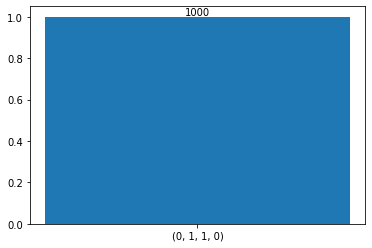

In [44]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})


qubits = cirq.LineQubit.range(4)
circuit = cirq.Circuit(cirq.X(qubits[1]), cirq.X(qubits[2]))

# Cargamos el circuito para la qft de cinco qubits.
qft_circ = QFT(qubits)

# Cargamos el circuito inverso al de la qft.
inv = cirq.inverse(qft_circ)

circuit.append(qft_circ)
circuit.append(inv)

# Medimos todos los qubits.
for qubit in qubits:
    circuit.append(cirq.measure(qubit))

print(circuit)
sim = cirq.Simulator()
results = sim.run(circuit, repetitions=1000).multi_measurement_histogram(keys=qubits)
plot_histogram(results)


Efectivamente, vemos que ausencia de ruido, el resultado siempre coincide con el valor incial de los qubits.

### AQFT

Definimos una función para crear el circuito para una AQFT. La función va a ser muy parecida a la de la QFT, pero limitando el número de rotaciones.

In [2]:
# Función que nos crea el circuito de la AQFT.
def AQFT(qubits, n_rot=2):

    N = len(qubits)
    circuit = cirq.Circuit()

    for i in range(N):
        circuit.append(cirq.H(qubits[i]))
        for j in range(i + 1, min(i+n_rot+1, N)):
            circuit.append(cirq.CZ(qubits[j], qubits[i])**(0.5**(j-i)))

    return circuit

Como antes, vamos a probar el circuito de antes para 2 qubits, mirando el state_vector de la simulación.

In [7]:
qubits = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.X(qubits[1]))

circuit.append(AQFT(qubits, n_rot=2))

print(circuit)

sim = cirq.Simulator()

sim.simulate(circuit)

0: ───────H───@───────────
              │
1: ───X───────@^0.5───H───


measurements: (no measurements)
output vector: 0.5|00⟩ - 0.5|01⟩ + 0.5j|10⟩ - 0.5j|11⟩

El resultado es el correcto.

Vamos a probar ahora con el segundo método que usamos anteriormente (Usando la AQFT inversa).

                      ┌───────┐           ┌───────┐                            ┌────────┐            ┌────────┐
0: ───X───H───@────────@──────────────────────────────────────────────────────────────────────────────@───────────@────────H───M───
              │        │                                                                              │           │
1: ───X───────@^0.5────┼─────H────@────────@────────────────────────────────────@───────────@─────────┼──────H────@^-0.5───M───────
                       │          │        │                                    │           │         │
2: ────────────────────@^0.25─────@^0.5────┼─────H────@───────────────@─────────┼──────H────@^-0.5────@^-0.25─────M────────────────
                                           │          │               │         │
3: ────────────────────────────────────────@^0.25─────@^0.5───H───H───@^-0.5────@^-0.25─────M──────────────────────────────────────
                      └───────┘           └───────┘       

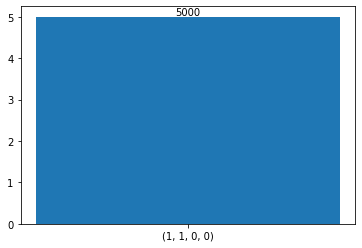

In [18]:
qubits = cirq.LineQubit.range(4)
circuit = cirq.Circuit(cirq.X(qubits[0]), cirq.X(qubits[1]))

aqft_cicuit = AQFT(qubits, n_rot=2)
inv = cirq.inverse(AQFT(qubits))

circuit.append(aqft_cicuit)
circuit.append(inv)

# Medimos todos los qubits.
for qubit in qubits:
    circuit.append(cirq.measure(qubit))

print(circuit)
sim = cirq.Simulator()
results = sim.run(circuit, repetitions=1000).multi_measurement_histogram(keys=qubits)
plot_histogram(results)

A la salida siempre medimos el mismo valor que tenían inicialmente los qubits, por lo que el circuito funciona correctamente.